# SageMaker Batch Transform using an XgBoost Bring Your Own Container (BYOC)

In this notebook, we will walk through an end to end data science workflow demonstrating how to build your own custom XGBoost Container using Amazon SageMaker Studio. We will first process the data using SageMaker Processing, push an XGB algorithm container to ECR, train the model, and use Batch Transform to generate inferences from your model in batch or offline mode. Finally we will use SageMaker Experiments to capture the metadata and lineage associated with the trained model. This is a key differentiator of SageMaker Studio as the metadata captured is visible in the Experiments UI. 


## The example

In this example we show how to package a custom XGBoost container with Amazon SageMaker studio with a Python example which works with the UCI Credit Card dataset. To use a different algorithm or a different dataset, you can easily change the Docker container and the xgboost folder attached with this code.

In this example, we use a single image to support training and hosting. This simplifies the procedure because we only need to manage one image for both tasks. Sometimes you may want separate images for training and hosting because they have different requirements. In this case, separate the parts discussed below into separate Dockerfiles and build two images. Choosing whether to use a single image or two images is a matter of what is most convenient for you to develop and manage.

If you're only using Amazon SageMaker for training or hosting, but not both, only the functionality used needs to be built into your container.

## The workflow

This notebook is divided into three parts: *exploring your data and feature engineering*, *building your contianer* and *using your container to train a model and generate inferences*

### The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

For the Python science stack, we start from an official TensorFlow docker image and run the normal tools to install TensorFlow Serving. Then we add the code that implements our specific algorithm to the container and set up the right environment for it to run under.

For details on how BYOC works with SageMaker Notebook instances, see this example: https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb. Unlike SageMaker notebook instances, in SageMaker studio as we will see below, you will not need the build_and_push.sh script anymore. The studio-build CLI will handle pushing the container to ECR for you. 

Let's look at the Dockerfile for this example.

In [ ]:
!cat Dockerfile

### Step 1: Pre-requisites: Download the necessary libraries

In [1]:
import sys

!{sys.executable} -m pip install "sagemaker-experiments"
!{sys.executable} -m pip install "sagemaker-studio-image-build"

  Created wheel for sagemaker-studio-image-build: filename=sagemaker_studio_image_build-0.6.0-py3-none-any.whl size=13453 sha256=af7d3902aaed3d120081e326edff64a826976f0d901e9eab215c6e50e81aedbe
  Stored in directory: /home/ubuntu/.cache/pip/wheels/c1/9c/e8/cbf0266d9d9b1b6161f7ba9ddf572d02aacd411e8a5b4d186b
Successfully built sagemaker-studio-image-build


### Prerequisites: Check the SageMaker SDK Version.

This notebook runs on SageMaker SDK Version < 2. Below we check the version, and if it is 2 or above, we reinstall the older version. If you see the "Please restart the kernel" prompt, simply click Kernel above and hit Restart.


In [2]:
# TO DELETE

import sagemaker 
if int(sagemaker.__version__.split('.')[0]) == 2:
    !{sys.executable} -m pip install "sagemaker>=1.71.0,<2.0.0"
    print("Installing previous SageMaker Version. Please restart the kernel")
else:
    print("Version is good")

     |████████████████████████████████| 299 kB 7.1 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.1-py2.py3-none-any.whl size=386572 sha256=d07416cdea8e928b4aa45c5865b3bbea8c46301e2ea3eb9698959c63f87ab8a7
  Stored in directory: /home/ubuntu/.cache/pip/wheels/93/16/0f/edaf643fd61fd04715a1d779fce966ca2a791d7386677fc395
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.40.1.dev0
    Uninstalling sagemaker-2.40.1.dev0:
      Successfully uninstalled sagemaker-2.40.1.dev0
Installing previous SageMaker Version. Please restart the kernel


In [3]:
!pip install -qU sagemaker

### Step 2: Ensure IAM Role has access to necessary services

The SageMaker Studio Image Build CLI uses Amazon Elastic Container Registry and AWS CodeBuild so we need to ensure that the role we provide as input to our CLI commands has the necessary policies and permissions attached. 

Two scenarios are supported including: 

   * **Add IAM Permissions to SageMaker Execution Role** 

   This scenario includes updating the Execution Role attached to this notebook instance with the required permissions.  In this scenario, you need to get the current execution role and ensure the trust policy and additional permissions are associated with the role.  
       
   * **Create/Utilize a secondary role with appropriate permissions attached** 

  This scenario include using a secondary role setup with the permissions below and identified in the --role argument when invoking the CLI (Example: *sm-docker build .  --role build-cli-role*)
    

**Ensure the role that will be used has the following**

1) Trust policy with CodeBuild

      {
      "Version": "2012-10-17",
      "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": [
              "codebuild.amazonaws.com"
            ]
          },
          "Action": "sts:AssumeRole"
        }
      ]
    }
    
2) Permissions attached to the execution role to execute a build in AWS CodeBuild, create ECR repository and push images to ECR 

     {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "codebuild:DeleteProject",
                "codebuild:CreateProject",
                "codebuild:BatchGetBuilds",
                "codebuild:StartBuild"
            ],
            "Resource": "arn:aws:codebuild:*:*:project/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogStream",
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:GetLogEvents",
                "logs:PutLogEvents"
            ],
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*:log-stream:*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogGroup",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "ecr:CreateRepository",
                "ecr:BatchGetImage",
                "ecr:CompleteLayerUpload",
                "ecr:DescribeImages",
                "ecr:DescribeRepositories",
                "ecr:UploadLayerPart",
                "ecr:ListImages",
                "ecr:InitiateLayerUpload",
                "ecr:BatchCheckLayerAvailability",
                "ecr:PutImage"
            ],
            "Resource": "arn:aws:ecr:*:*:repository/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "ecr:GetAuthorizationToken",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
              "s3:GetObject",
              "s3:DeleteObject",
              "s3:PutObject"
              ],
            "Resource": "arn:aws:s3:::sagemaker-*/*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:CreateBucket"
            ],
            "Resource": "arn:aws:s3:::sagemaker*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:GetRole",
                "iam:ListRoles"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": "iam:PassRole",
            "Resource": "arn:aws:iam::*:role/*",
            "Condition": {
                "StringLikeIfExists": {
                    "iam:PassedToService": "codebuild.amazonaws.com"
                }
            }
        }
    ]
}

### Restart Kernel

Once the libraries are installed, restart the kernel by clicking Kernel --> Restart and Running all the cells below.

In [4]:
# Let's inspect the role we have created for our notebook here:
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()
region = boto3.session.Session().region_name
print("Region = {}".format(region))
sm = boto3.Session().client("sagemaker")

Region = us-west-2


### Complete Setup: Import libraries and set global definitions.

All needed libraries will come pre-installed with this notebook with the Lifecycle configuration scripts.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import sleep, gmtime, strftime
import json
import time

In [6]:
# Import SageMaker Experiments

from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

### Specify buckets for storing data

In [7]:
# Use our custom bucket here.
rawbucket = sess.default_bucket()
prefix = "sagemaker-modelmonitor"  # use this prefix to store all files pertaining to this workshop.

dataprefix = prefix + "/data"
traindataprefix = prefix + "/train_data"
testdataprefix = prefix + "/test_data"
testdatanolabelprefix = prefix + "/test_data_no_label"
trainheaderprefix = prefix + "/train_headers"

### Step 3: Data Exploration

A key part of the data science lifecyle is data exploration, pre-processing and feature engineering. We will demonstrate how to use SM notebooks for data exploration and SM Processing for feature engineering and pre-processing data

### Download and Import the data

We will use the UCI Machine Learning Archive dataset on payment default for this example [https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+client]. Here we have a number of common features such as payment histories from prior months, payments, bills etc to predict a binary outcome -- whether or not a user will default on their payment in the following month.

In [9]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls -O data.xls

--2021-05-17 22:11:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5539328 (5.3M) [application/x-httpd-php]
Saving to: ‘data.xls’

data.xls            100%[===================>]   5.28M  11.3MB/s    in 0.5s    

2021-05-17 22:11:43 (11.3 MB/s) - ‘data.xls’ saved [5539328/5539328]



In [10]:
data = pd.read_excel("data.xls", header=1)
data = data.drop(columns=["ID"])
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [11]:
data.rename(columns={"default payment next month": "Label"}, inplace=True)
lbl = data.Label
data = pd.concat([lbl, data.drop(columns=["Label"])], axis=1)
data.head()

,Label,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,1,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,0,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [ ]:
COLS = data.columns

### Data Exploration

Once you have downloaded the dataset, the next step in the data science lifecycle is to explore the dataset. A correlation plot can indicate whether the features are correlated to one another and the label itself.

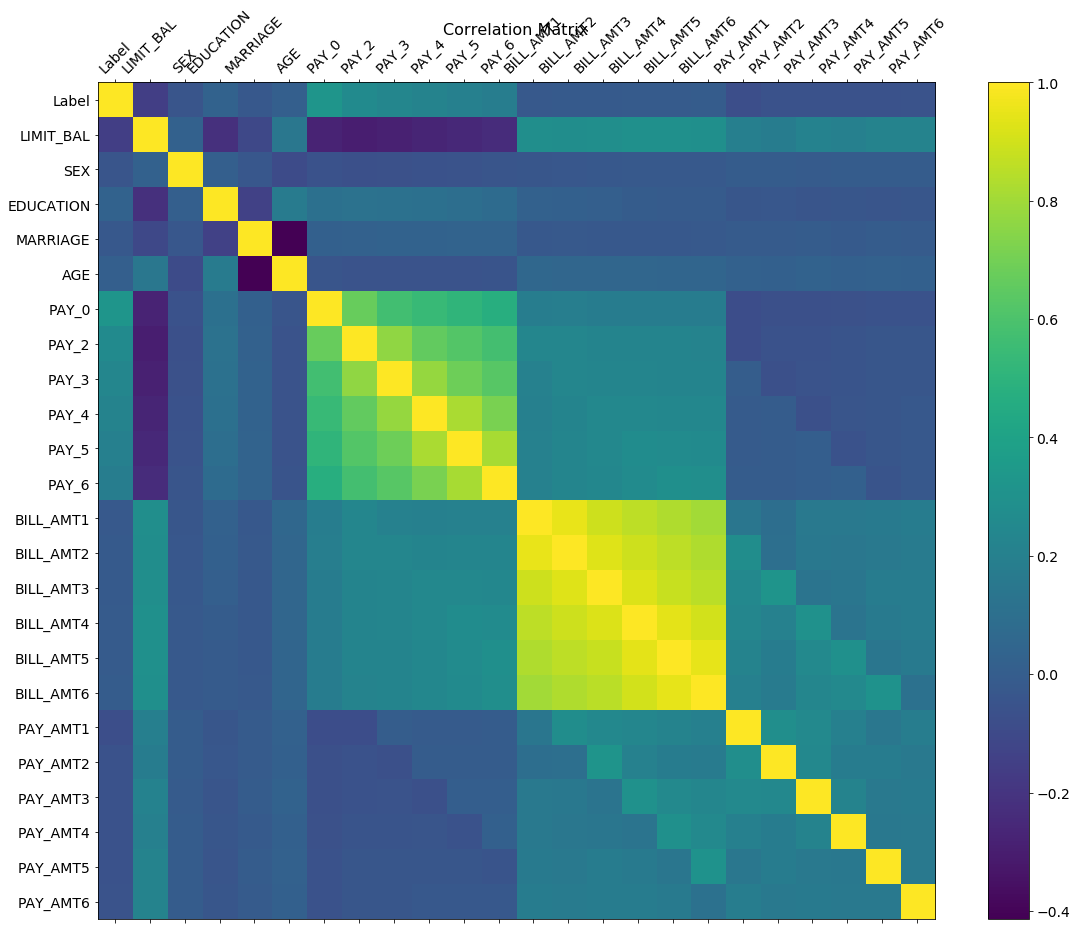

In [12]:
## Corr plot
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Correlation Matrix", fontsize=16);

In [ ]:
from pandas.plotting import scatter_matrix

SCAT_COLUMNS = ["BILL_AMT1", "BILL_AMT2", "PAY_AMT1", "PAY_AMT2"]
scatter_matrix(data[SCAT_COLUMNS], figsize=(10, 10), diagonal="kde")
plt.show()

### Step 4: Secure Feature Processing pipeline using SageMaker Processing

While you can pre-process small amounts of data directly in a notebook SageMaker Processing offloads the heavy lifting of pre-processing larger datasets by provisioning the underlying infrastructure, downloading the data from an S3 location to the processing container, running the processing scripts, storing the processed data in an output directory in Amazon S3 and deleting the underlying transient resources needed to run the processing job. Once the processing job is complete, the infrastructure used to run the job is wiped, and any temporary data stored on it is deleted.

In [13]:
if not os.path.exists('rawdata/rawdata.csv'):
    !mkdir rawdata
    data.to_csv('rawdata/rawdata.csv', index=None)
else:
    pass

In [14]:
# Upload the raw dataset
raw_data_location = sess.upload_data("rawdata", bucket=rawbucket, key_prefix=dataprefix)
print(raw_data_location)

s3://sagemaker-us-west-2-688520471316/sagemaker-modelmonitor/data


In [15]:
## Use SageMaker Processing with Sk Learn. -- combine data into train and test at this stage if possible.
from sagemaker.sklearn.processing import SKLearnProcessor

sklearn_processor = SKLearnProcessor(
    framework_version="0.20.0", role=role, instance_type="ml.c4.xlarge", instance_count=1
)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


### Write a preprocessing script (same as above)

In [16]:
%%writefile preprocessing.py

import argparse
import os
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import DataConversionWarning
from sklearn.compose import make_column_transformer

warnings.filterwarnings(action="ignore", category=DataConversionWarning)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--train-test-split-ratio", type=float, default=0.3)
    parser.add_argument("--random-split", type=int, default=0)
    args, _ = parser.parse_known_args()

    print("Received arguments {}".format(args))

    input_data_path = os.path.join("/opt/ml/processing/input", "rawdata.csv")

    print("Reading input data from {}".format(input_data_path))
    df = pd.read_csv(input_data_path)
    df.sample(frac=1)

    COLS = df.columns
    newcolorder = (
        ["PAY_AMT1", "BILL_AMT1"]
        + list(COLS[1:])[:11]
        + list(COLS[1:])[12:17]
        + list(COLS[1:])[18:]
    )

    split_ratio = args.train_test_split_ratio
    random_state = args.random_split

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop("Label", axis=1), df["Label"], test_size=split_ratio, random_state=random_state
    )

    preprocess = make_column_transformer(
        (["PAY_AMT1"], StandardScaler()), (["BILL_AMT1"], MinMaxScaler()), remainder="passthrough"
    )

    print("Running preprocessing and feature engineering transformations")
    train_features = pd.DataFrame(preprocess.fit_transform(X_train), columns=newcolorder)
    test_features = pd.DataFrame(preprocess.transform(X_test), columns=newcolorder)

    # concat to ensure Label column is the first column in dataframe
    train_full = pd.concat(
        [pd.DataFrame(y_train.values, columns=["Label"]), train_features], axis=1
    )
    test_full = pd.concat([pd.DataFrame(y_test.values, columns=["Label"]), test_features], axis=1)

    print("Train data shape after preprocessing: {}".format(train_features.shape))
    print("Test data shape after preprocessing: {}".format(test_features.shape))

    train_features_headers_output_path = os.path.join(
        "/opt/ml/processing/train_headers", "train_data_with_headers.csv"
    )

    train_features_output_path = os.path.join("/opt/ml/processing/train", "train_data.csv")

    test_features_output_path = os.path.join("/opt/ml/processing/test", "test_data.csv")

    print("Saving training features to {}".format(train_features_output_path))
    train_full.to_csv(train_features_output_path, header=False, index=False)
    print("Complete")

    print("Save training data with headers to {}".format(train_features_headers_output_path))
    train_full.to_csv(train_features_headers_output_path, index=False)

    print("Saving test features to {}".format(test_features_output_path))
    test_full.to_csv(test_features_output_path, header=False, index=False)
    print("Complete")

Writing preprocessing.py


In [17]:
# Copy the preprocessing code over to the s3 bucket
codeprefix = prefix + "/code"
codeupload = sess.upload_data("preprocessing.py", bucket=rawbucket, key_prefix=codeprefix)
print(codeupload)

s3://sagemaker-us-west-2-688520471316/sagemaker-modelmonitor/code/preprocessing.py


In [18]:
train_data_location = rawbucket + "/" + traindataprefix
test_data_location = rawbucket + "/" + testdataprefix
print("Training data location = {}".format(train_data_location))
print("Test data location = {}".format(test_data_location))

Training data location = sagemaker-us-west-2-688520471316/sagemaker-modelmonitor/train_data
Test data location = sagemaker-us-west-2-688520471316/sagemaker-modelmonitor/test_data


Next we will execute the script above using the managed scikit-learn preprocessing container. This step may take a few minutes to execute.

In [19]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(
    code=codeupload,
    inputs=[ProcessingInput(source=raw_data_location, destination="/opt/ml/processing/input")],
    outputs=[
        ProcessingOutput(
            output_name="train_data",
            source="/opt/ml/processing/train",
            destination="s3://" + train_data_location,
        ),
        ProcessingOutput(
            output_name="test_data",
            source="/opt/ml/processing/test",
            destination="s3://" + test_data_location,
        ),
        ProcessingOutput(
            output_name="train_data_headers",
            source="/opt/ml/processing/train_headers",
            destination="s3://" + rawbucket + "/" + prefix + "/train_headers",
        ),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2021-05-17-22-13-49-361



Job Name:  sagemaker-scikit-learn-2021-05-17-22-13-49-361
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-688520471316/sagemaker-modelmonitor/data', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-688520471316/sagemaker-modelmonitor/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-688520471316/sagemaker-modelmonitor/train_data', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'test_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sa

KeyboardInterrupt: 

# Part 2: Building the Container and Training the model


### Step 5: Set up SageMaker Experiments

In this notebook, we first build the Docker image by providing the Dockerfile discussed before and train a model using that Dockerfile

We use SageMaker Experiments for data scientists to track the lineage of the model from the raw data source to the preprocessing steps and the model training pipeline. With SageMaker Experiments, data scientists can compare, track and manage multiple diferent model training jobs, data processing jobs, hyperparameter tuning jobs and retain a lineage from the source data to the training job artifacts to the model hyperparameters and any custom metrics that they may want to monitor as part of the model training.


In [20]:
# Create a SageMaker Experiment
cc_experiment = Experiment.create(
    experiment_name=f"CreditCardDefault-{int(time.time())}",
    description="Predict credit card default from payments data",
    sagemaker_boto_client=sm,
)
print(cc_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7ff78055e990>,experiment_name='CreditCardDefault-1621289650',description='Predict credit card default from payments data',tags=None,experiment_arn='arn:aws:sagemaker:us-west-2:688520471316:experiment/creditcarddefault-1621289650',response_metadata={'RequestId': '2b9ab816-2563-4c70-a2ed-acb7fa0cf180', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2b9ab816-2563-4c70-a2ed-acb7fa0cf180', 'content-type': 'application/x-amz-json-1.1', 'content-length': '100', 'date': 'Mon, 17 May 2021 22:14:09 GMT'}, 'RetryAttempts': 0})


In addition to training, we want to track the lineage of the entire machine learing pipeline also including the processing job above. 

In [21]:
# Start Tracking parameters used in the Pre-processing pipeline.
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({"train_test_split_ratio": 0.2, "random_state": 0})
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="ccdefault-raw-dataset", media_type="s3/uri", value=raw_data_location)
    tracker.log_input(
        name="ccdefault-train-dataset", media_type="s3/uri", value=train_data_location
    )
    tracker.log_input(name="ccdefault-test-dataset", media_type="s3/uri", value=test_data_location)

ClientError: An error occurred (ValidationException) when calling the CreateTrialComponent operation: Trial Component creation is currently restricted to the SageMaker runtime. Try supplying an experiment config when creating a job instead.

### Step 6: Build XgBoost container for training

The code for the XGB container is already supplied with this notebook. We simply need to build this container and push it to ECR. The single line of code below will do it.

In [ ]:
!sm-docker build .

### Step 7: Train the Model

The same security postures we applied previously during SM Processing apply to training jobs. We will also have SageMaker experiments track the training job and store metadata such as model artifact location, training/validation data location, model hyperparameters etc.

As shown above, your image URI has the following form:
Image URI: {account-id}.dkr.ecr.{region}.amazonaws.com/sagemaker-studio-{studioID}:{username}

In [ ]:
account = sess.boto_session.client("sts").get_caller_identity()["Account"]
ecr = boto3.client("ecr")
domain_id = "sagemaker-studio-{}".format(sm.list_apps()["Apps"][0]["DomainId"])
image_tag = ecr.list_images(repositoryName=domain_id, filter={"tagStatus": "TAGGED"})["imageIds"][
    0
]["imageTag"]
image = "{}.dkr.ecr.{}.amazonaws.com/{}:{}".format(account, region, domain_id, image_tag)
preprocessing_trial_component = tracker.trial_component

trial_name = f"cc-fraud-training-job-{int(time.time())}"
cc_trial = Trial.create(
    trial_name=trial_name, experiment_name=cc_experiment.experiment_name, sagemaker_boto_client=sm
)

cc_trial.add_trial_component(preprocessing_trial_component)
cc_training_job_name = "cc-training-job-{}".format(int(time.time()))

xgb = sagemaker.estimator.Estimator(
    image,
    role,
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    train_max_run=86400,
    output_path="s3://{}/{}/models".format(rawbucket, prefix),
    sagemaker_session=sess,
)  # set to true for distributed training

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="binary:logistic",
    num_round=100,
)

xgb.fit(
    inputs={"training": "s3://" + train_data_location},
    job_name=cc_training_job_name,
    experiment_config={
        "TrialName": cc_trial.trial_name,  # log training job in Trials for lineage
        "TrialComponentDisplayName": "Training",
    },
    wait=True,
)
time.sleep(2)

Having used SageMaker Experiments to track the training runs, we can now extract model metadata to get the entire lineage of the model from the source data to the model artifacts and the hyperparameters.

To do this, simply call the **describe_trial_component** API.

In [ ]:
# Present the Model Lineage as a dataframe
from sagemaker.session import Session

session = boto3.Session()
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(session, sm),
    search_expression={
        "Filters": [{"Name": "Parents.TrialName", "Operator": "Equals", "Value": trial_name}]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)
lineagedf = lineage_table.dataframe()

lineagedf

In [ ]:
# get detailed information about a particular trial
sm.describe_trial_component(TrialComponentName=lineagedf.TrialComponentName[1])

# Part 3: Using the trained model for inference

### Step 8: Inference using Batch Transform

Let's first use Batch Transform to generate inferences for the test dataset you pre-processed before. 


In [ ]:
s3 = boto3.client("s3")
s3.download_file(rawbucket, testdataprefix + "/test_data.csv", "test_data.csv")

In [ ]:
newcolorder = (
    ["PAY_AMT1", "BILL_AMT1"] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]
)
test_full = pd.read_csv("test_data.csv", names=["Label"] + newcolorder)
test_full.head()

In [ ]:
test_data_no_label = test_full.drop(columns=["Label"], axis=1)
label = test_full["Label"]
test_data_no_label.to_csv("test_data_no_label.csv", index=False, header=False)
test_data_no_label.shape

In [ ]:
sess = sagemaker.Session()
test_data_nohead_location = sess.upload_data(
    "test_data_no_label.csv", bucket=rawbucket, key_prefix=testdatanolabelprefix
)

In [ ]:
%%time

sm_transformer = xgb.transformer(1, "ml.m5.xlarge", accept="text/csv")

# start a transform job
sm_transformer.transform(test_data_nohead_location, split_type="Line", content_type="text/csv")
sm_transformer.wait()

In [ ]:
import json
import io
from urllib.parse import urlparse


def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource("s3")
    obj = s3.Object(bucket_name, "{}/{}".format(prefix, file_name))
    return obj.get()["Body"].read().decode("utf-8")

In [ ]:
output = get_csv_output_from_s3(sm_transformer.output_path, "test_data_no_label.csv.out")
output_df = pd.read_csv(io.StringIO(output), sep=",", header=None)
output_df.head(8)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
1 - np.unique(data["Label"], return_counts=True)[1][1] / (len(data["Label"]))

In [ ]:
print(
    "Baseline Accuracy = {}".format(
        1 - np.unique(data["Label"], return_counts=True)[1][1] / (len(data["Label"]))
    )
)
print("Accuracy Score = {}".format(accuracy_score(label, output_df)))

In [ ]:
output_df["Predicted"] = output_df.values
output_df["Label"] = label
confusion_matrix = pd.crosstab(
    output_df["Predicted"],
    output_df["Label"],
    rownames=["Actual"],
    colnames=["Predicted"],
    margins=True,
)
confusion_matrix

### Step 9: Conclusions

In this notebook we demonstrated an end to end cycle of data exploration, data processing using SageMaker processing, model development using an XGBoost Bring Your Own Container which we pushed to ECR, model training and offline inference using Batch Transform. Finally we logged our training metadata using SageMaker Experiments.

You can use this notebook to experiment with end to end data science experimentation using SageMaker Studio. 


Remember to delete your datasets in the Amazon S3 bucket you used for this notebook.